In [701]:
import pandas as pd
from sklearn.metrics import auc, accuracy_score, confusion_matrix, mean_squared_error, roc_curve, roc_auc_score, precision_recall_curve, average_precision_score
from matplotlib import pyplot as plt
import seaborn as sns 
import re
import numpy as np
import scipy

In [524]:
data = pd.read_csv('../data/data_nc.nctools-predictions.txt', sep='\t')

In [525]:
cols_scores = [x for x in data.columns if re.search(r'NCBoost_Score|NCBoost_precomputed_score|NCBoost_chr|DeepSEA|ReMM|Eigen|LINSIGHT', x)]
cols_scores

['ReMM_score',
 'NCBoost_Score',
 'NCBoost_Score-merged-chrom-pos',
 'NCBoost_precomputed_score',
 'NCBoost_precomputed_score-merged-chrom-pos',
 'DeepSEA_Functional_significance_score',
 'Eigen-raw',
 'Eigen-phred',
 'Eigen PC-raw',
 'Eigen PC-phred',
 'Eigen-raw_merged-chr-pos',
 'Eigen PC-raw_merged-chr-pos',
 'Eigen-PC-raw_merged-chr-pos',
 'LINSIGHT_score']

In [526]:
data[['#Chrom', 'Pos', 'label'] + cols_scores].head(20)

,#Chrom,Pos,label,ReMM_score,NCBoost_Score,NCBoost_Score-merged-chrom-pos,NCBoost_precomputed_score,NCBoost_precomputed_score-merged-chrom-pos,DeepSEA_Functional_significance_score,Eigen-raw,Eigen-phred,Eigen PC-raw,Eigen PC-phred,Eigen-raw_merged-chr-pos,Eigen PC-raw_merged-chr-pos,Eigen-PC-raw_merged-chr-pos,LINSIGHT_score
0,1,21835920,Pathogenic,0.925,0.043725,0.043725,NaN,NaN,0.052103,1.238354,16.94820,4.016659,22.9740,1.238354,4.016659,NaN,0.113951
1,1,55505180,Pathogenic,0.611,0.271459,0.271459,NaN,NaN,0.066242,0.659571,12.95600,4.729346,25.1265,0.659571,4.729346,NaN,0.214607
2,1,113498814,Pathogenic,0.987,0.286262,0.286262,NaN,NaN,0.002187,2.062309,29.96190,6.894449,34.0382,2.062309,6.894449,NaN,0.055969
3,1,209975332,Pathogenic,0.931,0.233192,0.233192,NaN,NaN,0.019955,1.407326,18.67910,1.703142,16.7387,1.407326,1.703142,NaN,0.160774
4,1,209975361,Pathogenic,0.692,0.081881,0.081881,NaN,NaN,0.033797,0.769803,13.72960,1.578439,16.3985,0.769803,1.578439,NaN,0.081169
5,1,209979367,Pathogenic,0.921,0.161182,0.161182,NaN,NaN,0.006112,1.468657,19.47700,4.528953,24.4949,1.468657,4.528953,NaN,0.061968
6,1,209979435,Pathogenic,0.959,0.189841,0.189841,NaN,NaN,0.002021,1.475929,19.57810,4.260180,23.6961,1.475929,4.260180,NaN,0.274090
7,1,216596610,Pathogenic,0.913,0.257114,0.257114,NaN,NaN,0.010616,0.849738,14.25140,-0.038676,7.9590,0.849738,-0.038676,NaN,0.219858
8,1,228337561,Pathogenic,0.997,0.467702,0.467702,0.427995,0.427995,0.015348,1.784597,25.38060,3.232283,20.8083,1.784597,3.232283,NaN,0.671686
9,10,27389371,Pathogenic,0.986,0.162982,0.162982,NaN,NaN,0.007389,1.493691,4.85036,5.282147,27.0885,1.493691,5.282147,NaN,0.078774


In [1067]:
data_hc = data[(data.NCBoost_data == True) | (data.sample_weight == 1)]

print('Data info')
print(data.shape)
print(data.label.value_counts())

print('\nData high-confidence info')
print(data_hc.shape)
print(data_hc.label.value_counts())

Data info
(82188, 192)
Benign        79577
Pathogenic     2611
Name: label, dtype: int64

Data high-confidence info
(7308, 192)
Benign        5956
Pathogenic    1352
Name: label, dtype: int64


<h3>Scaling predictions between 0 - 1</h3>

To easily compare predictions with each other, scale all of them between 0 and 1. 

In [529]:
#Max values
data[cols_scores].max()

ReMM_score                                     1.000000
NCBoost_Score                                  0.918831
NCBoost_Score-merged-chrom-pos                 0.918831
NCBoost_precomputed_score                      0.953254
NCBoost_precomputed_score-merged-chrom-pos     0.953254
DeepSEA_Functional_significance_score          0.804400
Eigen-raw                                      3.834147
Eigen-phred                                   53.846400
Eigen PC-raw                                  10.676047
Eigen PC-phred                                50.580700
Eigen-raw_merged-chr-pos                       3.834147
Eigen PC-raw_merged-chr-pos                   10.676047
Eigen-PC-raw_merged-chr-pos                         NaN
LINSIGHT_score                                 0.993462
dtype: float64

In [530]:
#Min values
data[cols_scores].min()

ReMM_score                                    0.000000
NCBoost_Score                                 0.008056
NCBoost_Score-merged-chrom-pos                0.008056
NCBoost_precomputed_score                     0.009636
NCBoost_precomputed_score-merged-chrom-pos    0.009636
DeepSEA_Functional_significance_score         0.000010
Eigen-raw                                    -1.507438
Eigen-phred                                   0.000049
Eigen PC-raw                                 -0.365435
Eigen PC-phred                                0.000089
Eigen-raw_merged-chr-pos                     -1.507438
Eigen PC-raw_merged-chr-pos                  -0.365435
Eigen-PC-raw_merged-chr-pos                        NaN
LINSIGHT_score                                0.034344
dtype: float64

In [531]:
scale_min_max = lambda x: (data[x] - data[x].min()) / (data[x].max() - data[x].min())
for x in cols_scores:
    if 'DeepSEA' in x:
        #The DeepSEA functional significance is an e-value, so the lower the value, the more significant. 
        #Therefore convert values to value = 1 - value to easily compare it with the other tools.
        data[x] = data[x].apply(lambda x: 1-x)
    data[x + '-scaled'] = scale_min_max(x)

<h2>Plotting prediction scores for all tools</h2>

In [1039]:
def plot_scores_for_tools(df, columns, title, width=16, height=8, rename_tools=False):
    melted_df = pd.melt(df[columns + ['label']], id_vars='label', value_vars=columns)
    if rename_tools:
        melted_df['variable'] = melted_df.variable.apply(lambda x: re.split(r'-|_', x)[0])
    
    fig, axes = plt.subplots(1, 2, figsize=(width, height))
    plt.suptitle(title, fontsize=24, y=1.08)
    
    sns.violinplot(x='value', y="variable", hue='label', data=melted_df, palette="muted", split=True, cut=0, ax=axes[0])
    sns.boxplot(x='value', y="variable", hue='label', data=melted_df, palette="muted", showfliers=False, ax=axes[1])

    axes[0].legend(loc='center left', bbox_to_anchor=(1, 0.5))
    axes[1].get_legend().remove()
    
    for ax in axes:
        ax.set(xlabel='Score', ylabel='')

    plt.tight_layout()
    

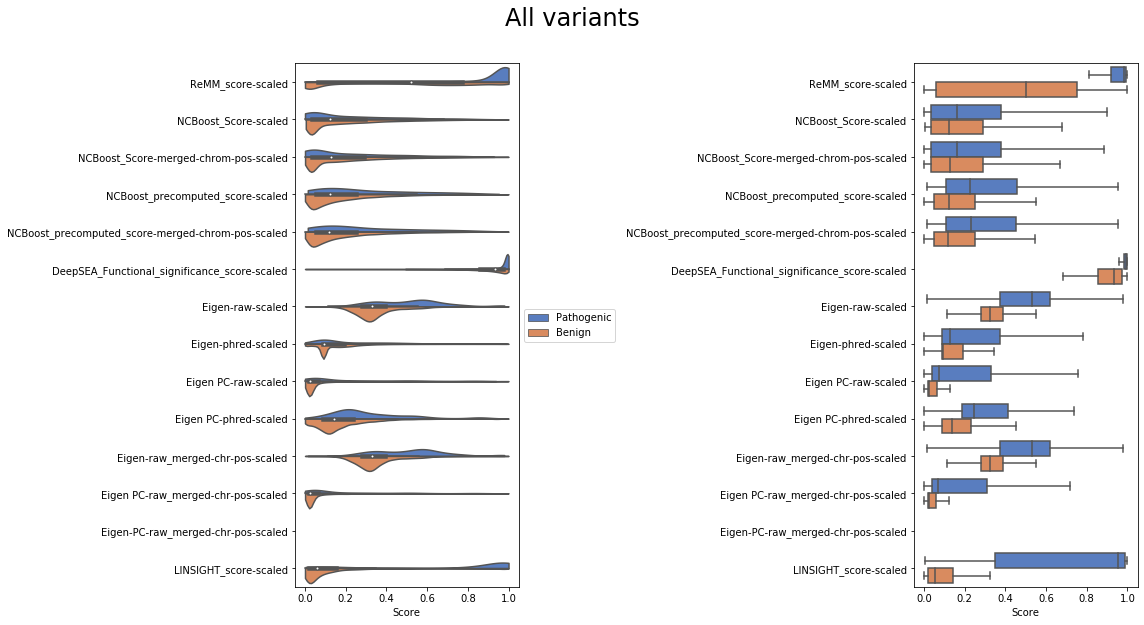

In [1040]:
cols_scores_scaled = [x + '-scaled' for x in cols_scores]
plot_scores_for_tools(data, columns=cols_scores_scaled, width=16, height=8, title='All variants')

The tools that seem to predict well are ReMM, DeepSEA, Eigen-raw and Linsight. The only tool that does not perform well is NCBoost. It's also weird that the precomputed NCBoost score seems to be better at discriminating than the NCBoost scores obtained by utilizing the tool. 

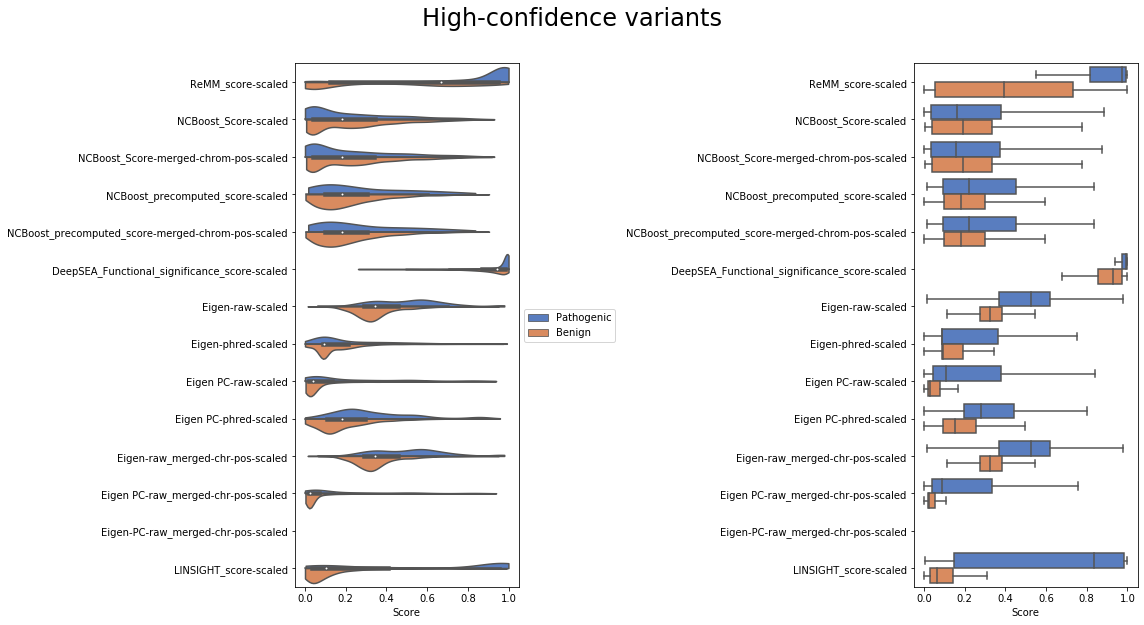

In [1041]:
cols_scores_scaled = [x + '-scaled' for x in cols_scores]
plot_scores_for_tools(data_hc, columns=cols_scores_scaled, width=16, height=8, title='High-confidence variants')

<h3>Cleaned up plots</h3>

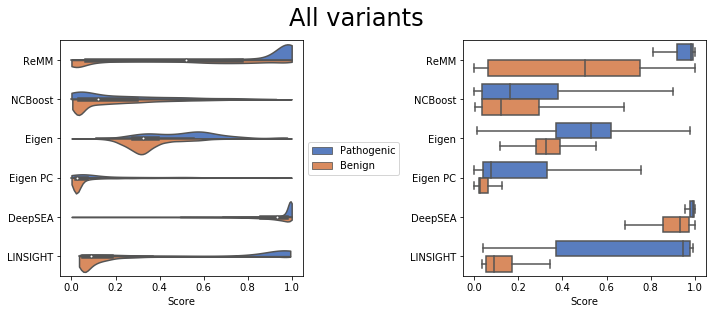

In [1042]:
cols = [
    'ReMM_score-scaled',
    'NCBoost_Score-scaled',
    'Eigen-raw-scaled',
    'Eigen PC-raw-scaled',
    'DeepSEA_Functional_significance_score-scaled',
    'LINSIGHT_score'
]

plot_scores_for_tools(data, columns=cols, width=10, height=4, rename_tools=True, title='All variants')

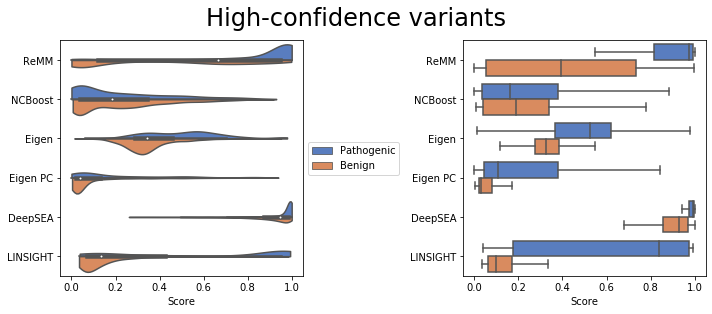

In [1043]:
plot_scores_for_tools(data_hc, columns=cols, width=10, height=4, rename_tools=True, title='High-confidence variants')

NCBoost performs worse than random here. Also interesting to see that for Eigen the pathogenic variants seem to form two distributions since Eigen is an unsupervised approach. <b>TODO:</b> investigate why Eigen predicts low scores for the left distribution. How are these variants ranked by the other tools? 

<h1>Precision recall plots</h1>

Only variants that have predictions for all tools can be used for the PR plot. This decreases the number of pathogenic variants we can use. 

In [1093]:
counts = lambda all_data, hc_data: pd.concat([all_data.label.value_counts().rename('All variants'), hc_data.label.value_counts().rename('High-confidence')], axis=1)

print('All data')
print(counts(data, data_hc))

print("\n\nSNV's")
print(counts(
    data[data.Ref.apply(lambda x: len(x) == 1) & data.Alt.apply(lambda x: len(x) == 1)],
    data_hc[data_hc.Ref.apply(lambda x: len(x) == 1) & data_hc.Alt.apply(lambda x: len(x) == 1)]
))

l = ['NCBoost_Score', 'ReMM_score', 'DeepSEA_Functional_significance_score', 'Eigen-raw', 'Eigen PC-raw', 'LINSIGHT_score']
print('\n\nVariants that have predictions for the tools', l)
print(counts(data.dropna(subset=l), data_hc.dropna(subset=l)))

l.remove('NCBoost_Score')
print('\n\nVariants that have predictions for the tools', l)
print(counts(data.dropna(subset=l), data_hc.dropna(subset=l)))
      

All data
            All variants  High-confidence
Benign             79577             5956
Pathogenic          2611             1352


SNV's
            All variants  High-confidence
Benign             69055             2273
Pathogenic          2369             1232


Variants that have predictions for the tools ['NCBoost_Score', 'ReMM_score', 'DeepSEA_Functional_significance_score', 'Eigen-raw', 'Eigen PC-raw', 'LINSIGHT_score']
            All variants  High-confidence
Benign             25594             1481
Pathogenic           484              439


Variants that have predictions for the tools ['ReMM_score', 'DeepSEA_Functional_significance_score', 'Eigen-raw', 'Eigen PC-raw', 'LINSIGHT_score']
            All variants  High-confidence
Benign             62655             2051
Pathogenic           859              670


If we will use all tools, only 484 pathogenic variants remain of which 439 are high-confidence. If we exclude NCBoost, 859 pathogenic variants remain of which 670 are high confidence.

In [1104]:
def plot_precision_recall_curve(df, cols):
    pr = []
    for tool in cols:
        p, r, t = precision_recall_curve(df['binarized_label'], df[tool])
        pr.append([tool, p, r, round(auc(r, p), 3)])

    plt.figure(figsize=(9, 5))
    pr = sorted(pr, key=lambda x: x[3])[::-1]
    for tool in pr:
        plt.plot(
            tool[2], #recall
            tool[1], #precision
            label='{} (AUC: {})'.format(
                re.split(r'-|_', tool[0])[0], 
                tool[3], 
#                 round(average_precision_score(df['binarized_label'], df[t[0]]), 3)
            )
        )
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.legend()

Precision recall plot for the variants for which we could retrieve predictions from all tools. 

Benign        25594
Pathogenic      484
Name: label, dtype: int64


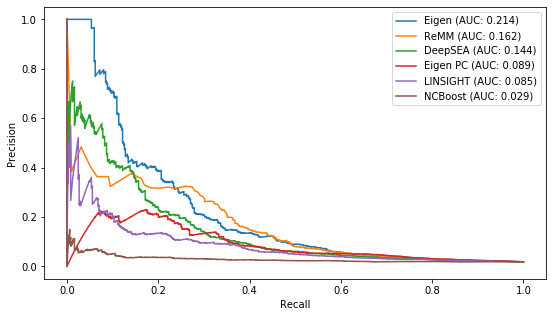

In [1105]:
data_filtered = data.dropna(subset=['NCBoost_Score', 'ReMM_score', 'DeepSEA_Functional_significance_score', 'Eigen-raw', 'Eigen PC-raw', 'LINSIGHT_score'])
print(data_filtered.label.value_counts())

plot_precision_recall_curve(data_filtered, cols=['NCBoost_Score', 'ReMM_score', 'DeepSEA_Functional_significance_score', 'Eigen-raw-scaled', 'Eigen PC-raw', 'LINSIGHT_score-scaled'])

For these 484 pathogenic variants and 25594 benign variants, Eigen performs best, followed by ReMM, DeepSEA, LiNSIGHT and lastly NCBoost. If NCBoost is left out, much more pathogenic variants remain in the data. Therefore also plot without NCBoost:

Benign        62655
Pathogenic      859
Name: label, dtype: int64


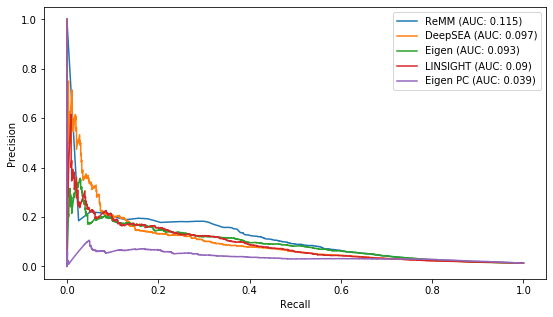

In [1083]:
data_filtered = data.dropna(subset=['ReMM_score', 'DeepSEA_Functional_significance_score', 'Eigen-raw', 'Eigen PC-raw', 'LINSIGHT_score'])
print(data_filtered.label.value_counts())

plot_precision_recall_curve(data_filtered, cols=['ReMM_score', 'DeepSEA_Functional_significance_score', 'Eigen-raw-scaled', 'Eigen PC-raw', 'LINSIGHT_score-scaled'])


Now, ReMM is best, followed by DeepSEA, Eigen and lastly LiNSIGHT. The plot is difficult to read because of the high number of benign variants. Also plot with high confidence SNPs only. This also might make the plot easier to read as the number of benign variants will be lowered a lot.

//anaconda3/envs/py3_vp/lib/python3.7/site-packages/ipykernel_launcher.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


Benign        2051
Pathogenic     670
Name: label, dtype: int64


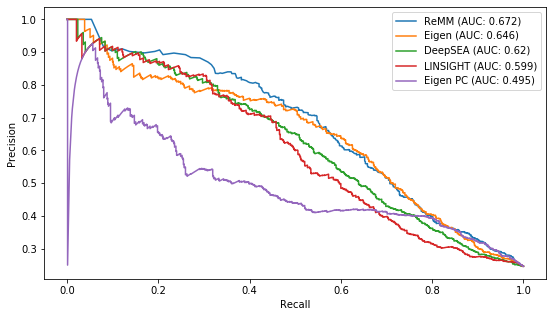

In [1084]:
data_filtered = data.dropna(subset=['ReMM_score', 'DeepSEA_Functional_significance_score', 'Eigen-raw', 'Eigen PC-raw', 'LINSIGHT_score'])
data_filtered_high_confidence = data_filtered[(data_filtered.NCBoost_data == True) | (data_snvs.sample_weight == 1)]
print(data_filtered_high_confidence.label.value_counts())

plot_precision_recall_curve(data_filtered_high_confidence, cols=['ReMM_score', 'DeepSEA_Functional_significance_score', 'Eigen-raw-scaled', 'Eigen PC-raw', 'LINSIGHT_score-scaled'])

Also plot high confidence SNPs with NCBoost included:

//anaconda3/envs/py3_vp/lib/python3.7/site-packages/ipykernel_launcher.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


Benign        1481
Pathogenic     439
Name: label, dtype: int64


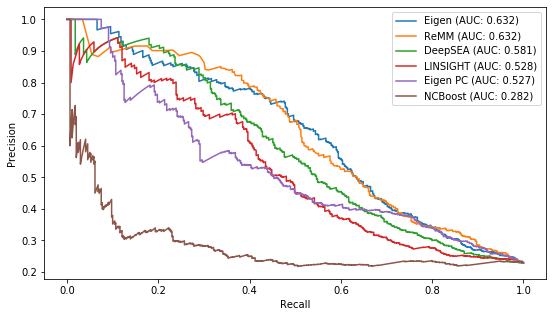

In [1085]:
data_filtered = data.dropna(subset=['NCBoost_Score', 'ReMM_score', 'DeepSEA_Functional_significance_score', 'Eigen-raw', 'Eigen PC-raw', 'LINSIGHT_score'])
data_filtered_high_confidence = data_filtered[(data_filtered.NCBoost_data == True) | (data_snvs.sample_weight == 1)]
print(data_filtered_high_confidence.label.value_counts())

plot_precision_recall_curve(data_filtered_high_confidence, cols=['NCBoost_Score', 'ReMM_score', 'DeepSEA_Functional_significance_score', 'Eigen-raw-scaled', 'Eigen PC-raw', 'LINSIGHT_score-scaled'])

<h1>Comparing performance in different genomic regions</h1>

Do comparisons both for all data and high confidence data. Leave NCBoost out because half of the pathogenic variants don't have an NCBoost score and it doesn't perform well anyway. 

<h3>Number of variants per region</h3>

In [1106]:
print('Numbers for all variants that have predictions for all tools')
counts = lambda pathogenic_data, benign_data: pd.concat([pathogenic_data.Consequence.value_counts().rename('Pathogenic'), benign_data.Consequence.value_counts().rename('Benign')], axis=1, sort=False)
data_filtered = data.dropna(subset=['ReMM_score', 'DeepSEA_Functional_significance_score', 'Eigen-raw', 'Eigen PC-raw', 'LINSIGHT_score'])
print(data_filtered.label.value_counts())
counts(data_filtered[data_filtered.label == 'Pathogenic'], data_filtered[data_filtered.label == 'Benign'])

Numbers for all variants that have predictions for all tools
Benign        62655
Pathogenic      859
Name: label, dtype: int64


,Pathogenic,Benign
INTRONIC,239.0,34755.0
UPSTREAM,238.0,6729.0
5PRIME_UTR,196.0,1062.0
DOWNSTREAM,103.0,11896.0
3PRIME_UTR,59.0,7227.0
NONCODING_CHANGE,21.0,980.0
SPLICE_SITE,3.0,NaN
INTERGENIC,NaN,6.0


In [1107]:
print('Numbers for high-confidence variants that have predictions for all tools')
data_filtered_hc = data_filtered[(data_filtered.NCBoost_data == True) | (data_filtered.sample_weight == 1)]
print(data_filtered_hc.label.value_counts())
counts = lambda pathogenic_data, benign_data: pd.concat([pathogenic_data.Consequence.value_counts().rename('Pathogenic'), benign_data.Consequence.value_counts().rename('Benign')], axis=1, sort=False)
counts(data_filtered_hc[data_filtered_hc.label == 'Pathogenic'], data_filtered_hc[data_filtered_hc.label == 'Benign'])

Numbers for high-confidence variants that have predictions for all tools
Benign        2051
Pathogenic     670
Name: label, dtype: int64


,Pathogenic,Benign
5PRIME_UTR,196,124.0
UPSTREAM,186,57.0
INTRONIC,181,1690.0
3PRIME_UTR,57,89.0
DOWNSTREAM,41,80.0
NONCODING_CHANGE,6,11.0
SPLICE_SITE,3,NaN


<h3>Score plots per region</h3>

In [ ]:
#Only use these regions as the others don't have enough variants
regions = ['INTRONIC', 'UPSTREAM', 'DOWNSTREAM', '5PRIME_UTR', '3PRIME_UTR']
tools = ['ReMM_score', 'DeepSEA_Functional_significance_score', 'Eigen-raw', 'Eigen PC-raw', 'LINSIGHT_score']

In [1108]:
# def plot_scores_and_average_precision_per_category(df, col):
def plot_scores_and_wilcox_z_per_category(df, col):
    fig, axes = plt.subplots(5, 2, figsize=(12, 16))
    axes = axes.flatten()

    for i in range(len(tools)):
        tool = tools[i]
        name = re.split(r'-|_', tool)[0]
        ax0 = axes[i*2]
        ax1 = axes[(i*2)+1]
        regions = list(set(df[col]))

        #Boxplots of scores
        sns.boxplot(
            x=tool,
            y=col,
            hue='label',
            data=df,
            palette='muted',
            showfliers=False,
            ax=ax0
        )
        ax0.set_title(name)
        ax0.set(xlabel=name + ' score')
        ax0.get_legend().remove()
        
        wilcoxon_results = [
            scipy.stats.ranksums(
                x=df[(df.label == 'Pathogenic') & (df['Consequence'] == region)][tool].tolist(),
                y=df[(df.label == 'Benign') & (df['Consequence'] == region)][tool].tolist()
            )
            for region in regions
        ]
        
        z_scores = [x[0] for x in wilcoxon_results]
        p_values = [str("%.3g" % x[1]) for x in wilcoxon_results]
        
        ax1.barh(y=p_values, width=z_scores)
        ax1.yaxis.set_label_position("right")
        ax1.yaxis.tick_right()
        ax1.set(xlabel='Wilcoxon Z-score', ylabel='P-value')
        ax1.set_title(name)
        
    plt.tight_layout()

Plots for all variants

Benign        62655
Pathogenic      859
Name: label, dtype: int64
Pathogenic variants per consequence:
INTRONIC            239
UPSTREAM            238
5PRIME_UTR          196
DOWNSTREAM          103
3PRIME_UTR           59
NONCODING_CHANGE     21
SPLICE_SITE           3
Name: Consequence, dtype: int64


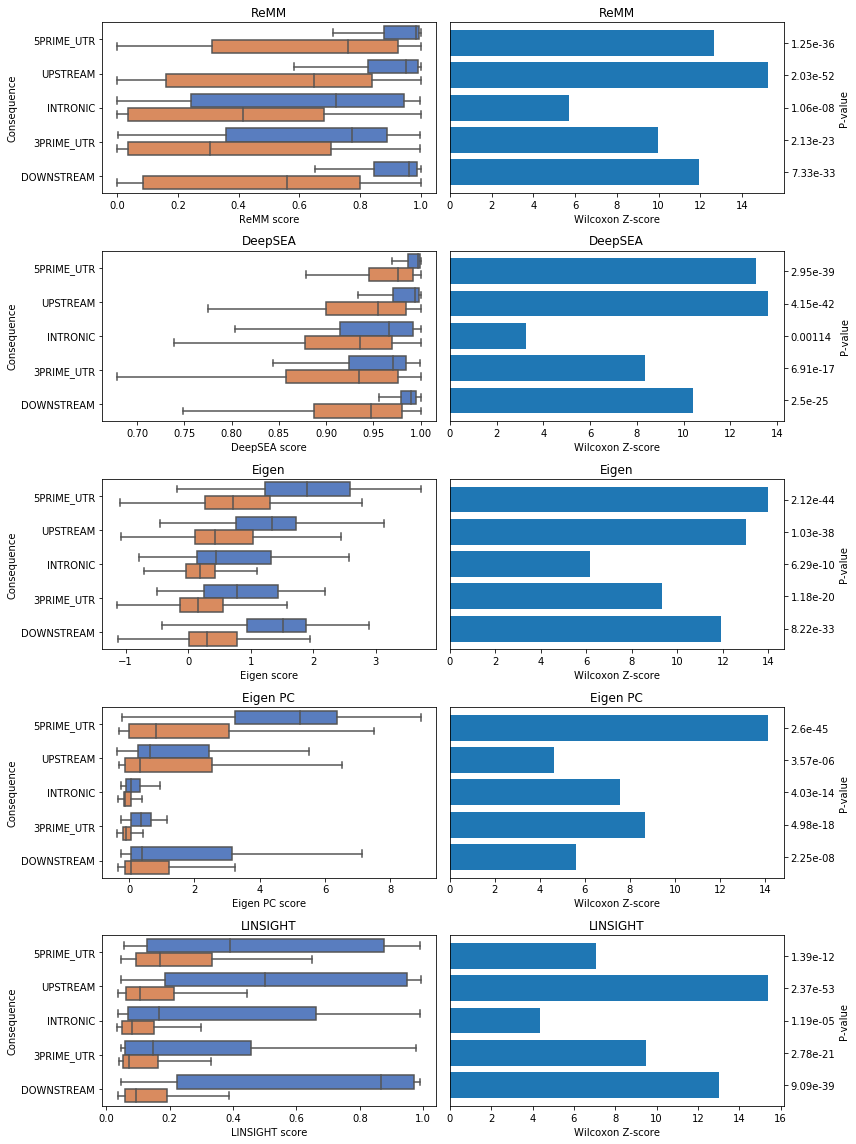

In [771]:
data_filtered = data_snvs.dropna(subset=['ReMM_score', 'DeepSEA_Functional_significance_score', 'Eigen-raw', 'Eigen PC-raw', 'LINSIGHT_score'])
print(data_filtered.label.value_counts())
print('Pathogenic variants per consequence:')
print(data_filtered[data_filtered.label == 'Pathogenic'].Consequence.value_counts())

plot_scores_and_wilcox_z_per_category(data_filtered[data_filtered.Consequence.isin(regions)], col='Consequence')

Plots for high-confidence SNPs only.

Benign        2051
Pathogenic     670
Name: label, dtype: int64
Pathogenic variants per consequence:
5PRIME_UTR          196
UPSTREAM            186
INTRONIC            181
3PRIME_UTR           57
DOWNSTREAM           41
NONCODING_CHANGE      6
SPLICE_SITE           3
Name: Consequence, dtype: int64


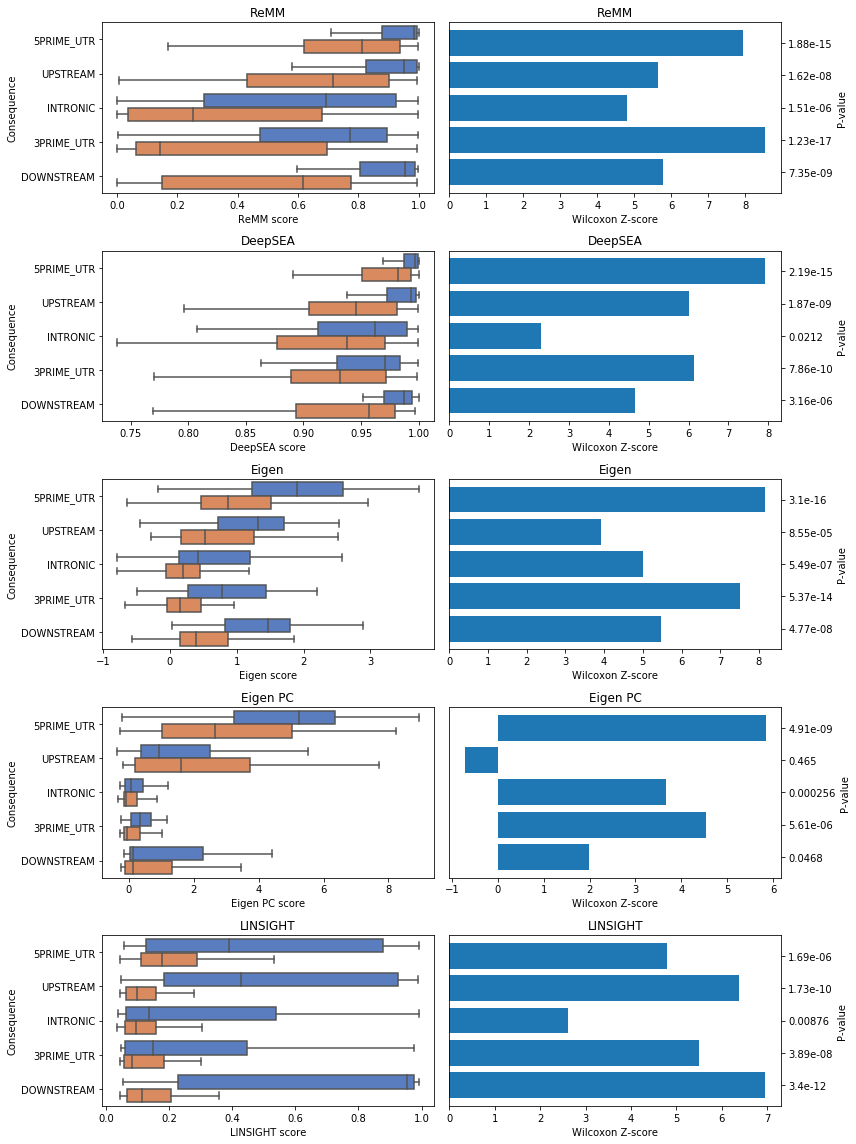

In [772]:
#Numbers for high confidence variants
data_filtered_high_confidence = data_snvs[(data_filtered.NCBoost_data == True) | (data_snvs.sample_weight == 1)]
print(data_filtered_high_confidence.label.value_counts())
print('Pathogenic variants per consequence:')
print(data_filtered_high_confidence[data_filtered_high_confidence.label == 'Pathogenic'].Consequence.value_counts())

plot_scores_and_wilcox_z_per_category(data_filtered_high_confidence[data_filtered_high_confidence.Consequence.isin(regions)], col='Consequence') 

In [973]:
def plot_ap_per_category_per_tool(df, col, tools, categories, rows, cols):

    df_filtered = df[df[col].isin(categories)]
    tool_names = [re.split(r'-|_', tool)[0] for tool in tools]
    
    #groups_af = data_filtered.groupby(bins)

    fig, axes = plt.subplots(rows, cols, figsize=(10, 5))
    axes = axes.flatten()
    
    for i in range(len(categories)):
        category = categories[i]
        ax = axes[i]
        df_filtered_category = df[df[col] == category]
        
        print(df_filtered_category.shape)
        aps = [average_precision_score(df_filtered_category.binarized_label, df_filtered_category[tool]) for tool in tools]
        ax.barh(y=tool_names, width=aps)
        ax.set(xlabel='Average precision')
        ax.set_title(category)
    
        plt.tight_layout()

    

Benign        2051
Pathogenic     670
Name: label, dtype: int64
Pathogenic variants per consequence:
5PRIME_UTR          196
UPSTREAM            186
INTRONIC            181
3PRIME_UTR           57
DOWNSTREAM           41
NONCODING_CHANGE      6
SPLICE_SITE           3
Name: Consequence, dtype: int64
['ReMM_score', 'DeepSEA_Functional_significance_score', 'Eigen-raw', 'Eigen PC-raw', 'LINSIGHT_score']
['INTRONIC', 'UPSTREAM', 'DOWNSTREAM', '5PRIME_UTR', '3PRIME_UTR']


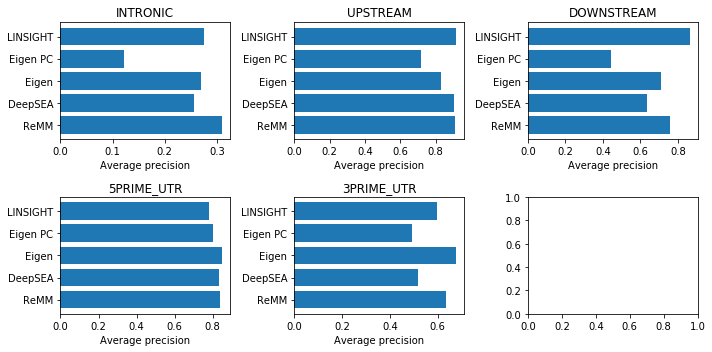

In [940]:
#Numbers for high confidence variants
data_filtered_high_confidence = data_snvs[(data_filtered.NCBoost_data == True) | (data_snvs.sample_weight == 1)]
print(data_filtered_high_confidence.label.value_counts())
print('Pathogenic variants per consequence:')
print(data_filtered_high_confidence[data_filtered_high_confidence.label == 'Pathogenic'].Consequence.value_counts())
print(tools)
print(regions)

plot_ap_per_category_per_tool(data_filtered_high_confidence, categories=regions, col='Consequence', tools=tools, rows=2, cols=3) 


Benign        62655
Pathogenic      859
Name: label, dtype: int64
Pathogenic variants per consequence:
INTRONIC            239
UPSTREAM            238
5PRIME_UTR          196
DOWNSTREAM          103
3PRIME_UTR           59
NONCODING_CHANGE     21
SPLICE_SITE           3
Name: Consequence, dtype: int64
(34994, 193)
(6967, 193)
(11999, 193)
(1258, 193)
(7286, 193)


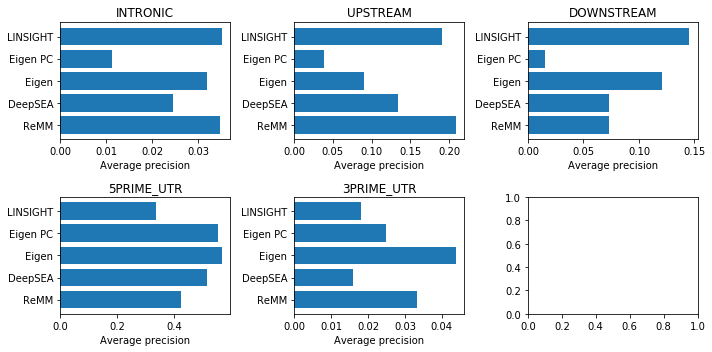

In [975]:
#Numbers for all variants
print(data_filtered.label.value_counts())
print('Pathogenic variants per consequence:')
print(data_filtered[data_filtered.label == 'Pathogenic'].Consequence.value_counts())

plot_ap_per_category_per_tool(data_filtered, categories=regions, col='Consequence', tools=tools, rows=2, cols=3) 


<h3>Comparing performance in different allele frequencies</h3>

In [927]:
bins = pd.cut(data_filtered.max_AF, [0.0, 0.000001, 0.00001, 0.0001, 0.001, 0.01, 1], include_lowest=True, right=False)
groups_af = data_filtered.groupby(bins)
for name, df in groups_af:
    print(name)
    print(df.label.value_counts())
data_filtered['bins'] = bins

[0.0, 1e-06)
Benign        7234
Pathogenic     186
Name: label, dtype: int64
[1e-06, 1e-05)
Benign        6120
Pathogenic      14
Name: label, dtype: int64
[1e-05, 0.0001)
Benign        15609
Pathogenic       47
Name: label, dtype: int64
[0.0001, 0.001)
Benign        8492
Pathogenic      61
Name: label, dtype: int64
[0.001, 0.01)
Benign        6140
Pathogenic      23
Name: label, dtype: int64
[0.01, 1.0)
Benign        18694
Pathogenic        9
Name: label, dtype: int64


//anaconda3/envs/py3_vp/lib/python3.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


(7420, 193)
(6134, 193)
(18703, 193)
(8553, 193)
(6163, 193)
(15656, 193)


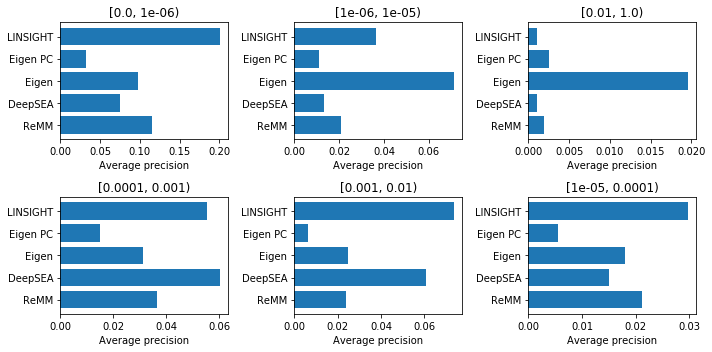

In [976]:
plot_ap_per_category_per_tool(data_filtered, categories=list(set(bins.dropna())), col='bins', tools=tools, rows=2, cols=3) 

In [178]:
confusion_matrix(train_filtered['binarized_label'], train_filtered['ReMM_score'].apply(lambda x: 1 if x > 0.8 else 0), labels=[1,0])

array([[  203,   103],
       [10827, 49139]])

In [199]:
data_filtered[data_filtered.NCBoost_data][['#Chrom', 'Pos', 'label', 'NCBoost_Score']].head(20)

,#Chrom,Pos,label,NCBoost_Score
0,1,21835920,Pathogenic,0.043725
1,1,55505180,Pathogenic,0.271459
2,1,113498814,Pathogenic,0.286262
3,1,209975332,Pathogenic,0.233192
4,1,209975361,Pathogenic,0.081881
5,1,209979367,Pathogenic,0.161182
6,1,209979435,Pathogenic,0.189841
7,1,216596610,Pathogenic,0.257114
8,1,228337561,Pathogenic,0.467702
9,10,27389371,Pathogenic,0.162982


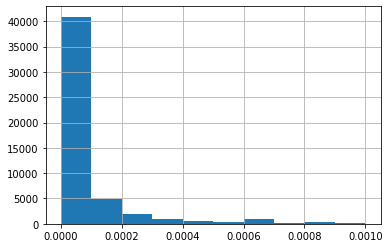

In [60]:
data.max_AF.hist(range=(0,0.001))


In [76]:
#data_copy = data
data_filtered.shape, data.shape

((63514, 190), (63514, 190))

In [260]:
bins = pd.cut(data_filtered.max_AF, [0.0, 0.000001, 0.00001, 0.0001, 0.001, 0.01, 1], include_lowest=True, right=False)
groups_af = data_filtered.groupby(bins)
for name, df in groups_af:
    print(name)
    print(df.label.value_counts())

[0.0, 1e-06)
Benign        7234
Pathogenic     186
Name: label, dtype: int64
[1e-06, 1e-05)
Benign        6120
Pathogenic      14
Name: label, dtype: int64
[1e-05, 0.0001)
Benign        15609
Pathogenic       47
Name: label, dtype: int64
[0.0001, 0.001)
Benign        8492
Pathogenic      61
Name: label, dtype: int64
[0.001, 0.01)
Benign        6140
Pathogenic      23
Name: label, dtype: int64
[0.01, 1.0)
Benign        18694
Pathogenic        9
Name: label, dtype: int64


In [320]:
tools = ['ReMM_score', 'DeepSEA_Functional_significance_score', 'Eigen-raw', 'Eigen PC-raw', 'LINSIGHT_score']
data_for_plotting = []


for name, df in groups_af:
    #sensitivity/recall = tp/tp+fn
    #specificity = tn/tn+fp
    #precision = tp/tp+fp
    print('AF: ', name)
    aps = [average_precision_score(df.binarized_label, df[tool]) for tool in tools]
#     aucs = []
#     for tool in tools:
#         p, r, t = precision_recall_curve(df['binarized_label'], df[tool])
#         a = auc(r, p)
#         aucs.append(a)
    #sort aps and tools, then append
    data_for_plotting.append([name, aps])
    print(aps)
#     print(aucs)
    print('\n')
  

AF:  [0.0, 1e-06)
[0.11536687685570395, 0.016288095368198918, 0.09817841963258914, 0.20102075053015406]


AF:  [1e-06, 1e-05)
[0.020632907001343705, 0.0016887077494386745, 0.07133919675611033, 0.03646812077571816]


AF:  [1e-05, 0.0001)
[0.02124049297858601, 0.0018515154635663006, 0.018087001062434, 0.029783656334647784]


AF:  [0.0001, 0.001)
[0.03650150016550143, 0.004331062803741071, 0.031317749695996086, 0.05535692049673011]


AF:  [0.001, 0.01)
[0.023690404321330148, 0.002494362688322334, 0.024758421005254456, 0.07374325383660318]


AF:  [0.01, 1.0)
[0.0019084468679778604, 0.0006232469575750486, 0.0195811431632575, 0.0010475523108431357]




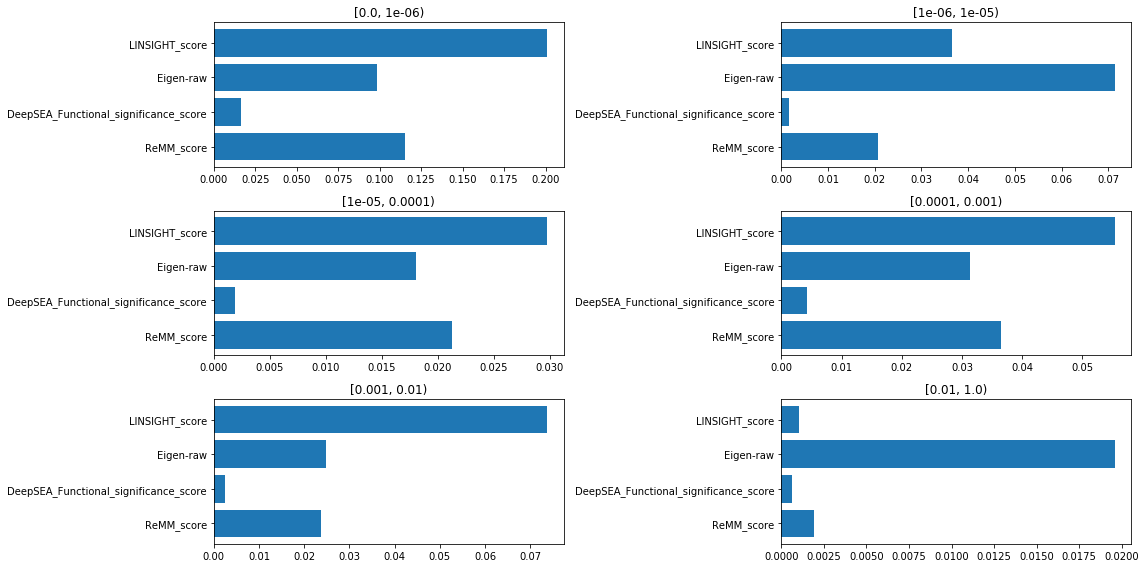

In [321]:
#plt.scatter([1,2,3,4], ['a', 'b', 'c', 'd'])
#data_for_plotting
fig, axes = plt.subplots(3, 2, figsize=(16, 8))

# for i in (0,1,2):
#     for e in (0,1):
#         print(e, i)

for n in range(len(axes.flatten())):
    ax = axes.flatten()[n]
    ax.barh(y=tools, width=data_for_plotting[n][1])
    ax.set_title(data_for_plotting[n][0])


plt.tight_layout()
plt.show()

#     pr = {}
#     for tool in cols:
#         p, r, t = precision_recall_curve(df['binarized_label'], df[tool])
#         pr[tool] = {'p': p, 'r': r, 't':t}
#round(auc(pr[t]['r'], pr[t]['p']), 2)))

In [329]:
data_filtered[data_filtered.label == 'Pathogenic'].Consequence.value_counts()

INTRONIC            239
UPSTREAM            238
5PRIME_UTR          196
DOWNSTREAM          103
3PRIME_UTR           59
NONCODING_CHANGE     21
SPLICE_SITE           3
Name: Consequence, dtype: int64

In [330]:
#Only use intronic, upstream, 5utr, downstream, 3utr bc of number of variants.

In [339]:
regions = data_filtered[data_filtered.label == 'Pathogenic'].Consequence.value_counts()[0:5].index.tolist()

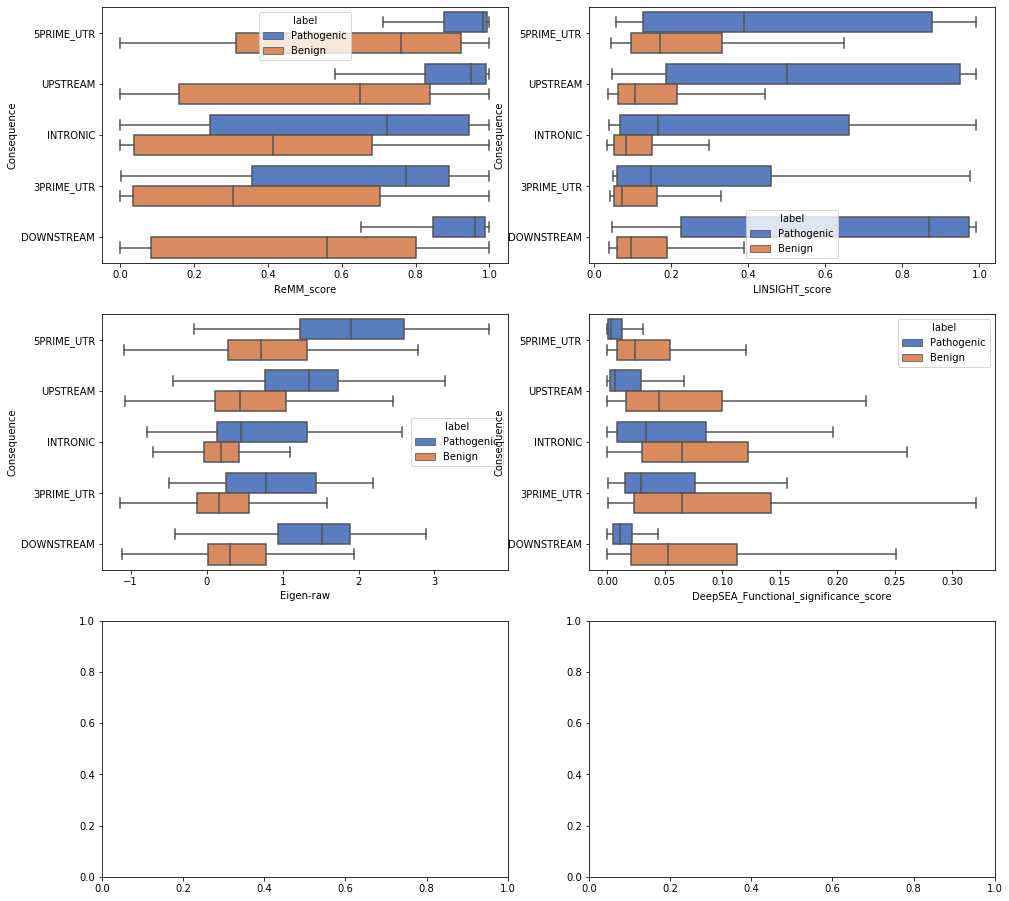

In [349]:
fig, axes = plt.subplots(3, 2, figsize=(16, 16))
axes = axes.flatten()
sns.boxplot(x='ReMM_score', y="Consequence", hue='label', data=data_filtered[data_filtered.Consequence.isin(regions)], palette="muted", showfliers=False, ax=axes[0])
sns.boxplot(x='LINSIGHT_score', y="Consequence", hue='label', data=data_filtered[data_filtered.Consequence.isin(regions)], palette="muted", showfliers=False, ax=axes[1])
sns.boxplot(x='Eigen-raw', y="Consequence", hue='label', data=data_filtered[data_filtered.Consequence.isin(regions)], palette="muted", showfliers=False, ax=axes[2])
sns.boxplot(x='DeepSEA_Functional_significance_score', y="Consequence", hue='label', data=data_filtered[data_filtered.Consequence.isin(regions)], palette="muted", showfliers=False, ax=axes[3])


In [ ]:
fig, axes = plt.subplots(3, 2, figsize=(16, 16))
axes = axes.flatten()
#sns.boxplot(x='ReMM_score', y="Consequence", hue='label', data=data_filtered, palette="muted", showfliers=False, ax=axes[0])



In [ ]:
#How to identify similarities/differences between tools.
#wilcoxon test for every tool for every consequence between pathogenic and benign.
#ReMM -> 5utr: 0.005, 3utr: 0.003, intronic: 0.3, etc.
#DeepSEA -> "..."

<h3>Comparing different allele frequencies</h3>

In [ ]:
#violinplots/boxplots of the score 